### Approximating the integral

It is easy to see that as we use large $n$ (i.e., more qubits) and thus larger $b_{\mbox{max}}$, we can approximate the integral better as illustrated below. 

In [1]:
import math

b_max = math.pi / 100  # upper limit of integral # 5
nbit = 20  # change this value to get discretized result closer to analytical results # 3

analyticResult = (b_max / 2.0 - math.sin(2 * b_max) / 4.0 ) / b_max  # the target integral can be analytically solved
print("Analytical Result:", analyticResult)

ndiv = 2**nbit  #number of discretization 
discretizedResult = 0.0
for i in range(ndiv):
    discretizedResult += math.sin(b_max / ndiv * (i + 0.5))**2
discretizedResult = discretizedResult / ndiv
print("Discretized Result:", discretizedResult)

Analytical Result: 0.00032892188007938847
Discretized Result: 0.00032892188007927603


### Grover Operators for Amplitude Estimation

We can easily build quantum circuits for fast computation of the Monte Carlo integration as below. Here, we show functions to construct quantum circuits running with simulators. Running them on real devices should be easy by adjusting the parameters of the functions.  

In [2]:
import sys
sys.path.append('../libmitigation')

In [3]:
#Preparing qiskit environment
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute
from qiskit import IBMQ
from qiskit import Aer
from scipy import optimize
import sys, time
import mpmath as mp
import numpy as np
import matplotlib.pyplot as plt

/Users/yangbo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/qiskit/__init__.py:67: DeprecationWarning: Using Qiskit with Python 3.6 is deprecated as of the 0.17.0 release. Support for running Qiskit with Python 3.6 will be removed in a future release.
  "future release.", DeprecationWarning)


In [4]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import depolarizing_error
import qiskit.ignis.mitigation as mit
from qiskit.ignis.mitigation.measurement import tensored_meas_cal, TensoredMeasFitter
import importlib
from inv_sgs import InvSGS
from inv_s_sgs import InvSSGS
from inv_lm_sgs import InvLMSGS
from inv_s_lm_sgs import InvSLMSGS
from inv_s_lm0_sgs import InvSLM0SGS
from inv_s_lmk_sgs import InvSLMkSGS
from mooney_etal import MooneyEtal
from sgs_algorithm import sgs_algorithm
from lib_grover import *

For example, quantum circuit with two Grover operators is shown below.

/Users/yangbo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/qiskit/visualization/matplotlib.py:291: DeprecationWarning: style option/s (usepiformat, cregbundle, compress) is/are not supported
  set_style(current_style, style)


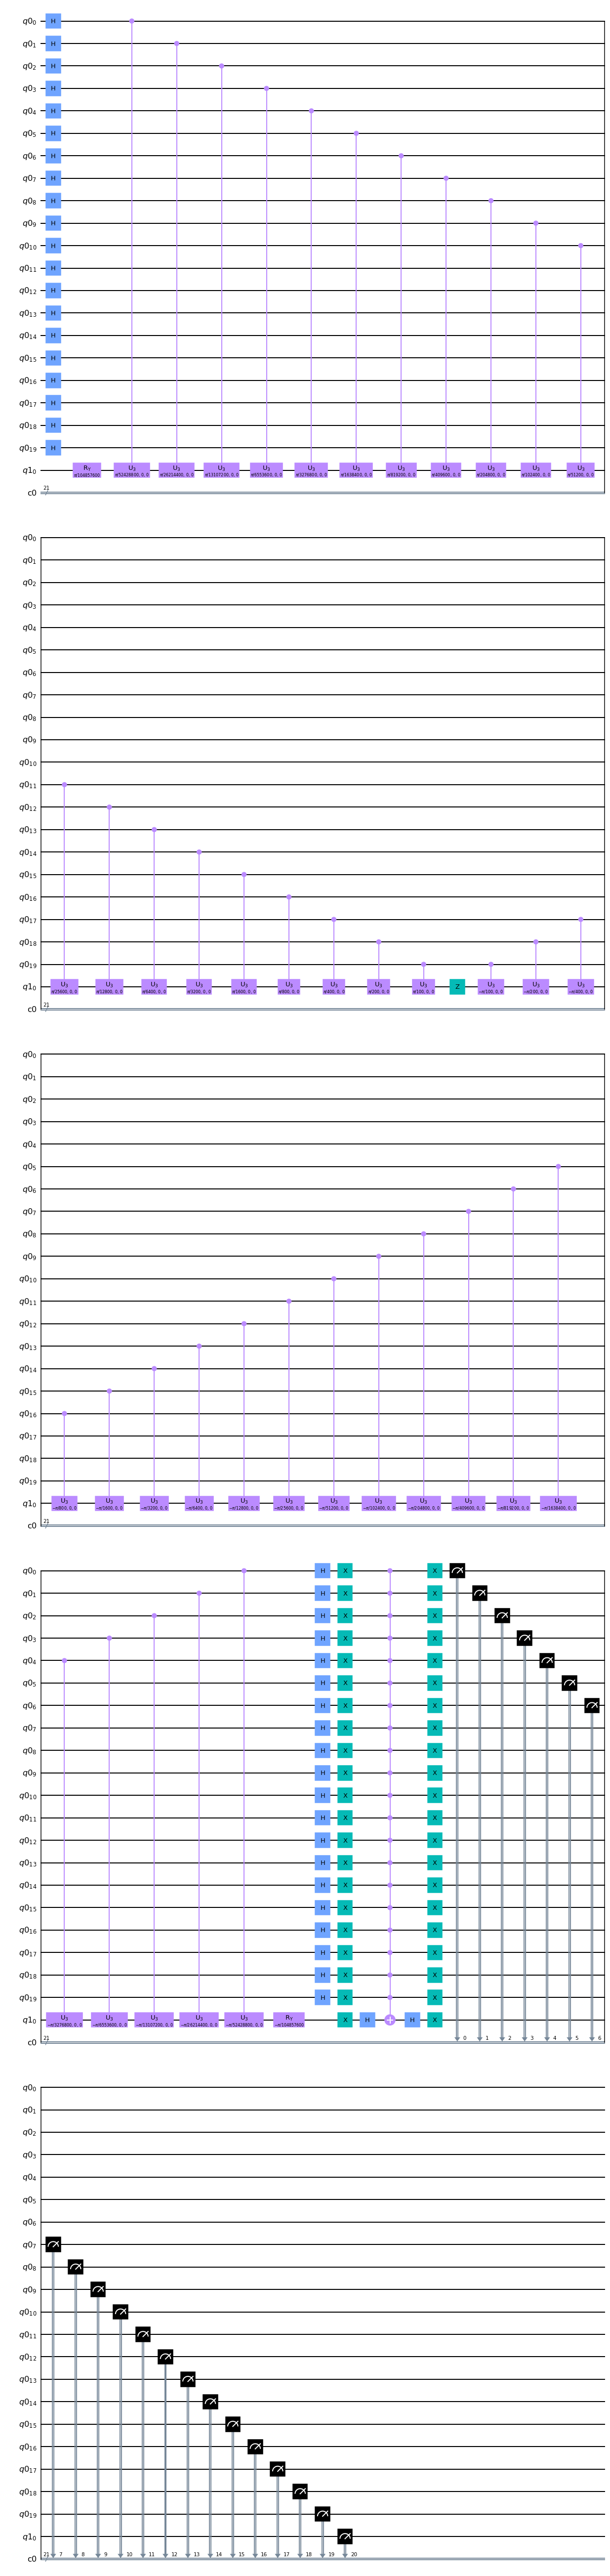

In [5]:
qc_list = create_grover_circuit([1], nbit, b_max)
my_style = {'usepiformat': True, 'cregbundle': True,'compress': True }
qc_list[0].draw(output="mpl", style=my_style, plot_barriers=False )

## Testing the algorithm with simulators

Let us run the algorithm with simulators

In [6]:
#setting the number of shots and Grover operators.

# number_grover_list = [0, 1, 2, 4, 8, 16, 32] # , 64, 128, 256]  # list of number of Grover operators
number_grover_list = [i for i in range(100)]
shots_list = [100] * len(number_grover_list) # list of number of shots
if len(shots_list) != len(number_grover_list):
    raise Exception(
        'The length of shots_list should be equal to the length of number_grover_list.'
    )

backend = Aer.get_backend('qasm_simulator')

In [7]:
noise_model = NoiseModel()
for qi in range(nbit+1):
    if qi >= 0:
        read_err = ReadoutError([[0.95, 0.05],[0.05,0.95]])
        noise_model.add_readout_error(read_err, [qi])

Finally, we can run the algorithm as below: 

In [13]:
qc_list = create_grover_circuit(number_grover_list, nbit,b_max)  # list of Grover circuits

In [13]:
counts_list = run_grover(qc_list, number_grover_list, shots_list, backend, noise_model=noise_model)  # list of number of grover operators

0 th round with 0 oracles
1.4070930480957031 s
1 th round with 1 oracles
0.2509899139404297 s
2 th round with 2 oracles
0.46913933753967285 s
3 th round with 3 oracles
0.6771457195281982 s
4 th round with 4 oracles
0.7533760070800781 s
5 th round with 5 oracles
0.9748020172119141 s
6 th round with 6 oracles
1.0727088451385498 s
7 th round with 7 oracles
1.6363401412963867 s
8 th round with 8 oracles
1.5438487529754639 s
9 th round with 9 oracles
2.275139808654785 s
10 th round with 10 oracles
2.7754008769989014 s
11 th round with 11 oracles
2.829711675643921 s
12 th round with 12 oracles
2.2864110469818115 s
13 th round with 13 oracles
3.452831983566284 s
14 th round with 14 oracles
3.2193310260772705 s
15 th round with 15 oracles
3.42372989654541 s
16 th round with 16 oracles
3.696410894393921 s
17 th round with 17 oracles
3.3652279376983643 s
18 th round with 18 oracles
3.543111801147461 s
19 th round with 19 oracles
3.798492908477783 s
20 th round with 20 oracles
4.374498128890991 s

In [15]:
import pickle
with open("raw_result_20_005_005.pkl", "wb") as f:
    pickle.dump(counts_list, f)

In [8]:
import pickle
with open("raw_result_20_005_005.pkl", "rb") as f:
    counts_list = pickle.load(f)

In [9]:
hit_list = make_hit_list(counts_list)
print(hit_list)

[30, 35, 29, 30, 30, 42, 32, 35, 28, 34, 25, 29, 32, 21, 23, 27, 21, 28, 23, 16, 20, 23, 16, 16, 9, 15, 15, 13, 13, 9, 11, 5, 6, 6, 6, 5, 2, 3, 7, 3, 1, 2, 1, 2, 4, 1, 3, 3, 3, 2, 5, 2, 2, 6, 4, 6, 7, 7, 13, 9, 10, 13, 12, 9, 20, 25, 24, 28, 26, 25, 19, 20, 19, 29, 27, 23, 32, 26, 35, 38, 32, 34, 32, 27, 39, 30, 42, 36, 38, 42, 36, 31, 36, 33, 32, 29, 27, 22, 24, 36]


In [10]:
shots = 8192
qr = QuantumRegister(nbit+1)
mit_pattern = [[i] for i in range(nbit+1)]
meas_calibs, state_labels = tensored_meas_cal(mit_pattern=mit_pattern, qr=qr, circlabel='mcal')
job = execute(meas_calibs, backend=Aer.get_backend('qasm_simulator'), shots=shots, noise_model=noise_model)
cal_results = job.result()
meas_fitter = TensoredMeasFitter(cal_results, mit_pattern=mit_pattern)

In [11]:
meas_filter = InvSLM0SGS(nbit+1, meas_fitter.cal_matrices, mit_pattern)
x_tilde_S_lm_0_list = []
for counts in counts_list:
    x_tilde = meas_filter.apply(counts)
    x_tilde_S_lm_0_list.append(x_tilde)
mit_hit_S_lm_0_list = make_hit_list(x_tilde_S_lm_0_list)
print(mit_hit_S_lm_0_list)

Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 2.0163413229140628
sum of mitigated probability vector x_hat_s: 2.0163411430886597
0.10306525230407715 s
number of positive values:  40
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 2.0258621067890394
sum of mitigated probability vector x_hat_s: 2.025861971274829
0.05792117118835449 s
number of positive values:  36
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 2.1088497177982166
sum of mitigated probability vector x_hat_s: 2.108849564590079
0.09926891326904297 s
number of positive values:  45
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 2.1488144322538263
sum of mitigated probability vector x_hat_s: 2.148814191702343
0.09418082237243652 s
number

sum of mitigated probability vector x_s: 2.25970476088311
sum of mitigated probability vector x_hat_s: 2.2597045962332714
0.08253693580627441 s
number of positive values:  40
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 2.2447225437814624
sum of mitigated probability vector x_hat_s: 2.2447222884249483
0.12691307067871094 s
number of positive values:  49
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 2.256034963509801
sum of mitigated probability vector x_hat_s: 2.2560347226401873
0.12690281867980957 s
number of positive values:  50
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 2.260950784727603
sum of mitigated probability vector x_hat_s: 2.2609505418881204
0.10975480079650879 s
number of positive values:  46
main process: Done!
Restriction to labels

sum of mitigated probability vector x_s: 2.2724982900490116
sum of mitigated probability vector x_hat_s: 2.2724980558976133
0.12133312225341797 s
number of positive values:  46
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 2.1723578947997493
sum of mitigated probability vector x_hat_s: 2.172357667706107
0.12358307838439941 s
number of positive values:  45
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 2.1589234637529495
sum of mitigated probability vector x_hat_s: 2.158923242553873
0.11236286163330078 s
number of positive values:  45
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 2.193157865498748
sum of mitigated probability vector x_hat_s: 2.1931576570217577
0.09408187866210938 s
number of positive values:  36
main process: Done!
Restriction to label

sum of mitigated probability vector x_s: 2.142071521209401
sum of mitigated probability vector x_hat_s: 2.1420713316610795
0.14344382286071777 s
number of positive values:  46
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 2.136020195218666
sum of mitigated probability vector x_hat_s: 2.1360200066748845
0.11922788619995117 s
number of positive values:  43
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 2.006316367664861
sum of mitigated probability vector x_hat_s: 2.006316196754315
0.09270405769348145 s
number of positive values:  39
main process: Done!
[81.01894956069209, 94.9511986369487, 80.24632366727054, 83.4492242636588, 80.33062891038053, 100.0, 86.69892369934003, 97.52151458143994, 78.02325749651787, 93.5981748907569, 64.78752959389102, 79.2812831571333, 87.49571866212129, 54.17903007874288, 61.6765184153521, 74.28453662427

In [12]:
meas_filter = MooneyEtal(nbit+1, meas_fitter.cal_matrices, mit_pattern)
x_tilde_mooney_list = []
for counts in counts_list:
    x_tilde = meas_filter.apply(counts, threshold=1/100)
    x_tilde_mooney_list.append(x_tilde)
mit_hit_mooney100_list = make_hit_list(x_tilde_mooney_list)
print(mit_hit_mooney100_list)

The heuristcs by Mooney et al. + SGS algorithm
{65540: 0.02761205440059632, 11264: 0.029104838914688253, 8200: 0.028337647915314852, 260: 0.0292092376607107, 65552: 0.02875165821599067, 1048832: 0.02351589025128914, 73728: 0.02760380623282609, 10240: 0.027258009588192484, 524800: 0.029210966620422288, 65536: -0.02035981765649029, 24576: 0.027590036231177985, 256: -0.022702875783503856, 1048576: 0.10623432509726316, 34816: 0.026966144145624975, 4132: 0.02980856664582819, 8704: 0.027475512844362025, 16400: 0.027108030994722077, 136: 0.029783137689033637, 32784: 0.025144207684006638, 32768: 0.04556454271235578, 524288: -0.01851842439384096, 2048: -0.020820434505969754, 540672: 0.029663095322391735, 262144: 0.16836481616781743, 131072: 0.015436994579562595, 6404: 0.030733766449590395, 1088: 0.029208132062925395, 8448: 0.028658883944800595, 2050: 0.026666175144873253, 278528: 0.019683865143759083, 0: 0.8644787087451522, 4096: -0.019472186917137747, 204800: 0.02914518978409132, 4100: 0.02755

{1057800: 0.030942820376929005, 1048640: 0.03513221793463728, 1114120: 0.02731732665151395, 1049092: 0.029077776672622038, 1054720: 0.027453112370825677, 1572992: 0.027527513063720907, 1319440: 0.03037953685266962, 1049348: 0.028967394657053516, 1049632: 0.029557774595401064, 1573124: 0.030769193272466723, 4: 0.06703296815251798, 1376288: 0.030963531305067616, 128: 0.036006695122683396, 32772: 0.027511863967845652, 1310720: 0.038865509405250666, 139264: 0.029229458219524024, 1048645: 0.030761592425670396, 1081856: 0.03070981016136802, 0: 0.41664173982416985, 1572864: 0.033098049506397526, 526336: 0.030824672825665166, 524296: 0.031210157606933825, 131104: 0.02974187902952426, 1576960: 0.025766576781618578, 1835008: 0.025925722955020547, 32896: 0.02906272329895525, 2050: 0.02891774066538241, 1052672: 0.03484317874647867, 1706496: 0.030584055547674013, 1049856: 0.029170533973617786, 1048576: 0.378400521688815, 256: 0.033952901049794676, 64: 0.037036263362996875, 1638400: 0.02767445311814

{64: 0.023220147287541612, 2048: 0.019275679865204644, 8192: 0.053464836139005906, 1572993: 0.030907912980794185, 512: 0.02248840272818526, 1583112: 0.030942820353158016, 1703936: 0.014464880800867415, 66564: 0.030702400181483236, 1310736: 0.05212957243117031, 1057792: 0.026751818916523246, 1122818: 0.03031838470277993, 526848: 0.030741437885541865, 134144: 0.03066296502487573, 1343488: 0.02281919488272974, 1052688: 0.03050506123112124, 1311248: 0.027412758803989103, 1179904: 0.025653377073436102, 1056800: 0.027016546160466864, 6144: 0.029545101470509635, 1179648: 0.04096401572132053, 1081344: 0.04153660245134059, 33028: 0.030840287768058736, 1310720: 0.09738413974894321, 1048836: 0.030713945266077795, 1180184: 0.030617896775961804, 128: 0.0211385041662132, 17: 0.02908506518017532, 1064976: 0.028838496995340603, 1605760: 0.030864230349635743, 1048608: 0.04345033264529975, 1136640: 0.030750524775951225, 1581312: 0.029056837524939424, 1184000: 0.02921202040141195, 1311752: 0.031018600561

{1118209: 0.03074189959850032, 2560: 0.028961226755904082, 1572900: 0.02859196198460396, 1024: 0.020096501397777158, 16384: 0.020098434090609428, 1573376: 0.022452062006504472, 1180672: 0.029104998425507986, 2048: 0.01640582060012049, 65536: 0.01677965318299795, 1573409: 0.031090584752819974, 1589312: 0.028158737680225258, 1081344: 0.03567401111749331, 1081728: 0.03075340016641347, 1573890: 0.03056494367985703, 1049856: 0.03066281940671866, 589824: 0.028192276505117717, 1574432: 0.03097113522442464, 1049216: 0.03070594133742452, 1572868: 0.04703173908520079, 1574912: 0.052263750329421314, 262144: 0.020073503134806003, 1181696: 0.029078097963329573, 1088: 0.029208132062925395, 1052928: 0.02740237861408868, 524288: 0.013450596023212871, 262176: 0.02974036172901361, 1589248: 0.02197425201220576, 131072: 0.02166983556875491, 48: 0.029526173119345495, 4354: 0.030639422761364228, 1056768: 0.030042467980496448, 18432: 0.028285536720530958, 1314816: 0.029200151988106153, 1114112: 0.06372383637

{1048586: 0.02921569223697801, 1638417: 0.030481693813713205, 1114112: 0.09556750341755674, 96: 0.03109093203882554, 2056: 0.028713743089468894, 1572874: 0.029326627873353828, 1097728: 0.02935239971924949, 1179712: 0.027432912656285315, 524288: 0.09480785841418278, 1343520: 0.031102771068582145, 1835008: 0.019764838754727277, 1835026: 0.030356858723410624, 1065024: 0.02754309750163689, 8193: 0.030895737451169313, 1054720: 0.02906985699478983, 1049090: 0.05768664490111912, 8: 0.042834764928689935, 1049600: 0.09398180125988047, 1049104: 0.02695079935089086, 1048704: 0.03227110990695426, 1576964: 0.030848448325959513, 1057026: 0.03046273656797612, 1573376: 0.017382066816810936, 1048640: 0.03076156595906156, 131088: 0.030536310063800618, 0: 0.3585572595958414, 2560: 0.03068623971568198, 1049088: 0.025753601232757436, 1572864: 0.1794870080998705, 1048576: 0.47911956639057013, 1056768: 0.06234314344913671}
sum of counts: 2.094385590318932
0.00592803955078125 s
number of positive values:  31


{49152: 0.031083514326149135, 64: -0.03501508907792757, 8450: 0.02908407830020835, 8198: 0.02910488023297665, 33312: 0.031098449721248138, 147496: 0.03157345182222172, 4160: 0.027832909377849765, 135232: 0.02925153901704123, 163840: 0.0279564463431467, 2177: 0.030848492940203306, 1: -0.03214932083692049, 516: 0.027573009097560625, 262144: 0.028718293646839296, 0: 1.1557165872826396, 1544: 0.029348417411783442, 524288: -0.031184796128664302, 1032: 0.028054964877424798, 262208: 0.027944449480619794, 320: 0.032322958453585314, 8192: -0.03870169628888134, 8208: 0.031054259985191957, 131328: 0.02750838911685985, 8194: 0.025774938554687706, 2048: -0.0312992197818061, 262178: 0.03097951648690208, 16: -0.041321173340827015, 1049220: 0.030701997599775235, 528456: 0.031162357395631165, 68608: 0.030596257206288845, 2066: 0.03027125822524913, 32769: 0.03089626548071147, 260: 0.030820536078697863, 524416: 0.02936689033572168, 524352: 0.03101225880488041, 1048576: 0.031087811559911735, 1024: -0.0310

In [13]:
meas_filter = MooneyEtal(nbit+1, meas_fitter.cal_matrices, mit_pattern)
x_tilde_mooney_list = []
for counts in counts_list:
    x_tilde = meas_filter.apply(counts, threshold=1/10)
    x_tilde_mooney_list.append(x_tilde)
mit_hit_mooney10_list = make_hit_list(x_tilde_mooney_list)
print(mit_hit_mooney10_list)

The heuristcs by Mooney et al. + SGS algorithm
{0: 0.9198264275280504}
sum of counts: 0.9198264275280504
0.0008912086486816406 s
number of positive values:  1
accumulator is positive, we might even ignoring the necessal positive values.
main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{0: 1.0758702540657592}
sum of counts: 1.0758702540657592
0.00055694580078125 s
number of positive values:  1
main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{0: 0.8922336991941133}
sum of counts: 0.8922336991941133
0.0006120204925537109 s
number of positive values:  1
accumulator is positive, we might even ignoring the necessal positive values.
main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{0: 0.9247573870375106}
sum of counts: 0.9247573870375106
0.0011451244354248047 s
number of positive values:  1
accumulator is positive, we might even ignoring the necessal positive values.
main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{0: 0

main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{0: 1.1067502887393372}
sum of counts: 1.1067502887393372
0.0005388259887695312 s
number of positive values:  1
main process: Done!
[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 58.37356398826603, 63.25001470522778, 51.78454155581782, 38.867247138399094, 0, 58.40611694567421, 51.77443034407705, 51.83959072359548, 46.90865928557807, 0, 32.35406474393206, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 26.08867935159209, 0, 33.872237749605226, 42.150767240448474, 46.81202837739339, 0, 61.430700869815844, 71.25887389499852, 69.63395876939991, 77.74956007909609, 61.580730070314274, 72.96019750530024, 100.0, 59.90241665240193, 63.03482512521092, 100.0, 75.69261491799995, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.

In [21]:
import pickle
with open("hit_list_20_005_005.pkl", "wb") as f:
    pickle.dump(hit_list, f)

In [22]:
# import pickle
# with open("mit_hit_S_list_20_005_005.pkl", "wb")as f:
#     pickle.dump(mit_hit_S_list, f)

In [13]:
import pickle
with open("mit_hit_S_lm_0_list_20_005_005.pkl", "wb")as f:
    pickle.dump(mit_hit_S_lm_0_list, f)

In [14]:
import pickle
with open("mit_hit_mooney100_list_20_005_005.pkl", "wb") as f:
    pickle.dump(mit_hit_mooney_list, f)

In [20]:
with open("hit_list_20_005_005.pkl", "rb") as f:
    hit_list = pickle.load(f)
with open("mit_hit_S_lm_0_list_20_005_005.pkl", "rb") as f:
    mit_hit_S_lm_0_list = pickle.load(f)
with open("mit_hit_mooney100_list_20_005_005.pkl", "rb") as f:
    mit_hit_mooney_list = pickle.load(f)

Text(0, 0.5, 'number of shots for $|00...0>$')

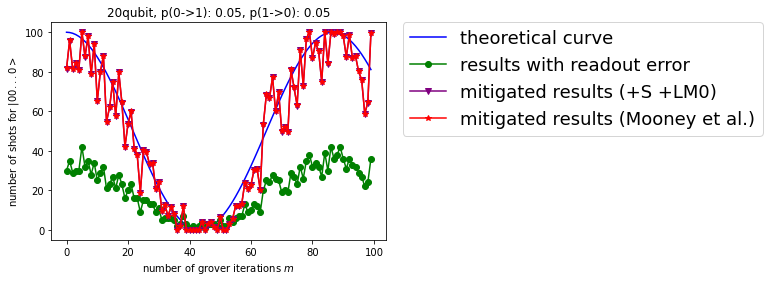

In [15]:
divide = 100
number_grover_list = [i for i in range(100)]
plt.plot(np.linspace(0,number_grover_list[-1], divide), 100 * np.cos(2 * np.linspace(0,number_grover_list[-1], divide) * np.arccos(np.sqrt(discretizedResult))) ** 2, label="theoretical curve", color="blue")
plt.plot(number_grover_list, hit_list, marker="o", label="results with readout error", color="green")
plt.plot(number_grover_list, mit_hit_S_lm_0_list, marker="v", label="mitigated results (+S +LM0)", color="purple")
plt.plot(number_grover_list, mit_hit_mooney_list, marker="*", label="mitigated results (Mooney et al.)", color="red")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
plt.title("20qubit, p(0->1): 0.05, p(1->0): 0.05")
plt.xlabel("number of grover iterations $m$")
plt.ylabel("number of shots for $|00...0>$")

In [14]:
sin_hit_list = [100 - h for h in hit_list]
sin_mit_hit_S_lm_0_list = [100 - h for h in mit_hit_S_lm_0_list]
sin_mit_hit_mooney100_list = [100 - h for h in mit_hit_mooney100_list]
sin_mit_hit_mooney10_list = [100 - h for h in mit_hit_mooney10_list]

thetaCandidate_list = calculate_theta(
    sin_hit_list, number_grover_list, shots_list)  # list of estimated theta values
thetaCandidate_mit_S_lm_0_list = calculate_theta(
    sin_mit_hit_S_lm_0_list, number_grover_list, shots_list)  # list of estimated theta values
thetaCandidate_mit_mooney100_list = calculate_theta(
    sin_mit_hit_mooney100_list, number_grover_list, shots_list)  # list of estimated theta values
thetaCandidate_mit_mooney10_list = calculate_theta(
    sin_mit_hit_mooney10_list, number_grover_list, shots_list)  # list of estimated theta values

error_list = np.abs(np.sin(thetaCandidate_list)**2 - discretizedResult)  # list of estimation errors
error_mit_S_lm_0_list = np.abs(np.sin(thetaCandidate_mit_S_lm_0_list)**2 - discretizedResult)  # list of estimation errors
error_mit_mooney100_list = np.abs(np.sin(thetaCandidate_mit_mooney100_list)**2 - discretizedResult)  # list of estimation errors
error_mit_mooney10_list = np.abs(np.sin(thetaCandidate_mit_mooney10_list)**2 - discretizedResult)  # list of estimation errors
OracleCall_list = []  # list of number of oracle calls
ErrorCramérRao_list = []  # list of Cramér-Rao lower bound
for i in range(len(number_grover_list)):
    OracleCall_list.append(
        CalcNumberOracleCalls(i, shots_list, number_grover_list))
    ErrorCramérRao_list.append(
        CalcErrorCramérRao(i, shots_list, discretizedResult, number_grover_list))

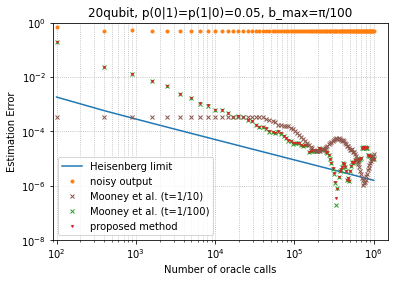

In [15]:
plt.clf()
p = plt.loglog( OracleCall_list, ErrorCramérRao_list)
p0 = plt.loglog( OracleCall_list, error_list, 'o', markersize=3)
p2 = plt.loglog( OracleCall_list, error_mit_mooney100_list, 'x', color='C2', markersize=4)
p3 = plt.loglog( OracleCall_list, error_mit_S_lm_0_list, 'v', color='C3', markersize=2)
p4 = plt.loglog( OracleCall_list, error_mit_mooney10_list, 'x', color='C5', markersize=4)

plt.title("20qubit, p(0|1)=p(1|0)=0.05, b_max=π/100")
plt.xlim(OracleCall_list[0]*0.9, OracleCall_list[-1]*1.5)
plt.xlabel("Number of oracle calls")
plt.ylim(0.00000001, 1)
plt.ylabel("Estimation Error")
plt.grid(True, which="both", ls="dotted")
plt.legend((p[0], p0[0], p4[0], p2[0], p3[0]), ("Heisenberg limit", "noisy output", "Mooney et al. (t=1/10)", "Mooney et al. (t=1/100)", "proposed method"))
plt.show()